<a href="https://colab.research.google.com/github/ArthurFA001/Datos-Omicos/blob/main/Clasificador_convolucional_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


#descargar set de datos de MNIST (numeros escritos a mano, etiquetados)

datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

#Obtener variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_prueba = datos['train'], datos['test']

#Funcion de normalizacion  para los datos (Pasar color de los pixeles de 0-255 a 0-1)

def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui se pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento con la funcion
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_prueba = datos_prueba.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_prueba.cache()

clases = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

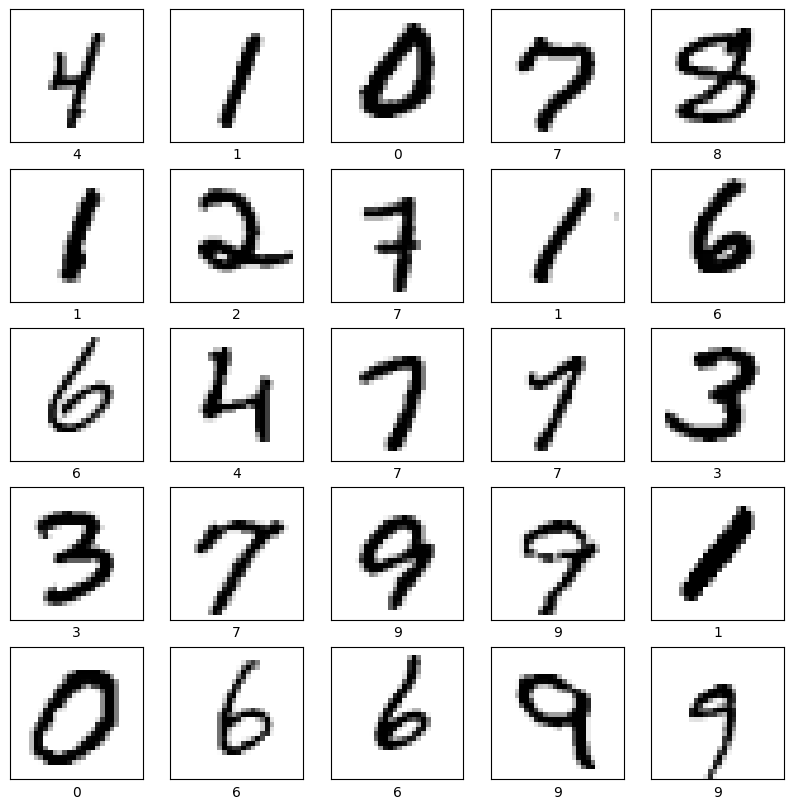

In [ ]:
#Codigo para mostrar imagenes del set, no es necesario ejecutarlo, solo imprime unos numeros

plt.figure(figsize=(10,10))

for i, (imagen,etiqueta) in enumerate(datos_entrenamiento.take(25)):

  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(clases[etiqueta])

plt.show()

In [ ]:
#Crear el modelo convolucional
#Cuenta con 1 capa de convolución con 32 núcleos y otra con 64. 2 capas de agrupación.
#Finalmente una capa densa con 100 neuronas

modelo = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupacion

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamaño de la matriz de agrupacion

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
#Los numeros de datos de entrenamiento y pruebas (60k y 10k)
num_datos_entrenamiento = metadatos.splits["train"].num_examples
num_datos_pruebas = metadatos.splits["test"].num_examples

#Trabajar por lotes
TAMANO_LOTE=32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria
#para que el entrenamiento no se aprenda las cosas en orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
#Realizar el entrenamiento
import math

historial = modelo.fit(
    datos_entrenamiento,
    epochs=60,
    steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANO_LOTE)
)

Epoch 1/60
1875/1875 [==============================] - 60s 28ms/step - loss: 0.1316 - accuracy: 0.9597
Epoch 2/60
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0406 - accuracy: 0.9875
Epoch 3/60
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0290 - accuracy: 0.9907
Epoch 4/60
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0214 - accuracy: 0.9935
Epoch 5/60
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0161 - accuracy: 0.9948
Epoch 6/60
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0128 - accuracy: 0.9956
Epoch 7/60
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0102 - accuracy: 0.9967
Epoch 8/60
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0085 - accuracy: 0.9975
Epoch 9/60
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0073 - accuracy: 0.9975
Epoch 10/60
1875/1875 [==============================] - 53s 28m

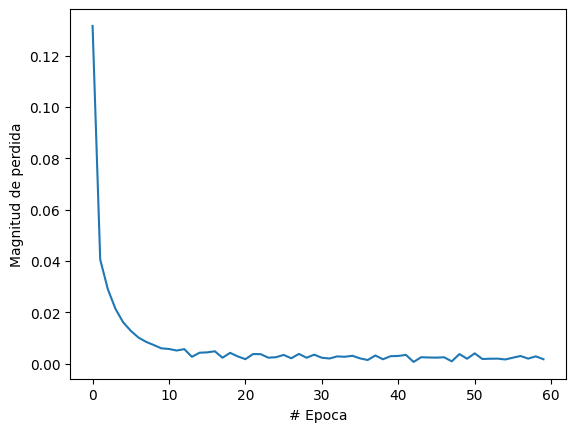

In [ ]:
#Grafica del reduccion del error durante el entrenamiento

plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

In [ ]:
#Exportar el modelo al explorador
modelo.save('numeros_regular.h5')

#Convertirlo a tensorflow.js
!pip install tensorflowjs

!mkdir carpeta_salida

!tensorflowjs_converter --input_format keras numeros_regular.h5 carpeta_salida